['counts[110] = 976']


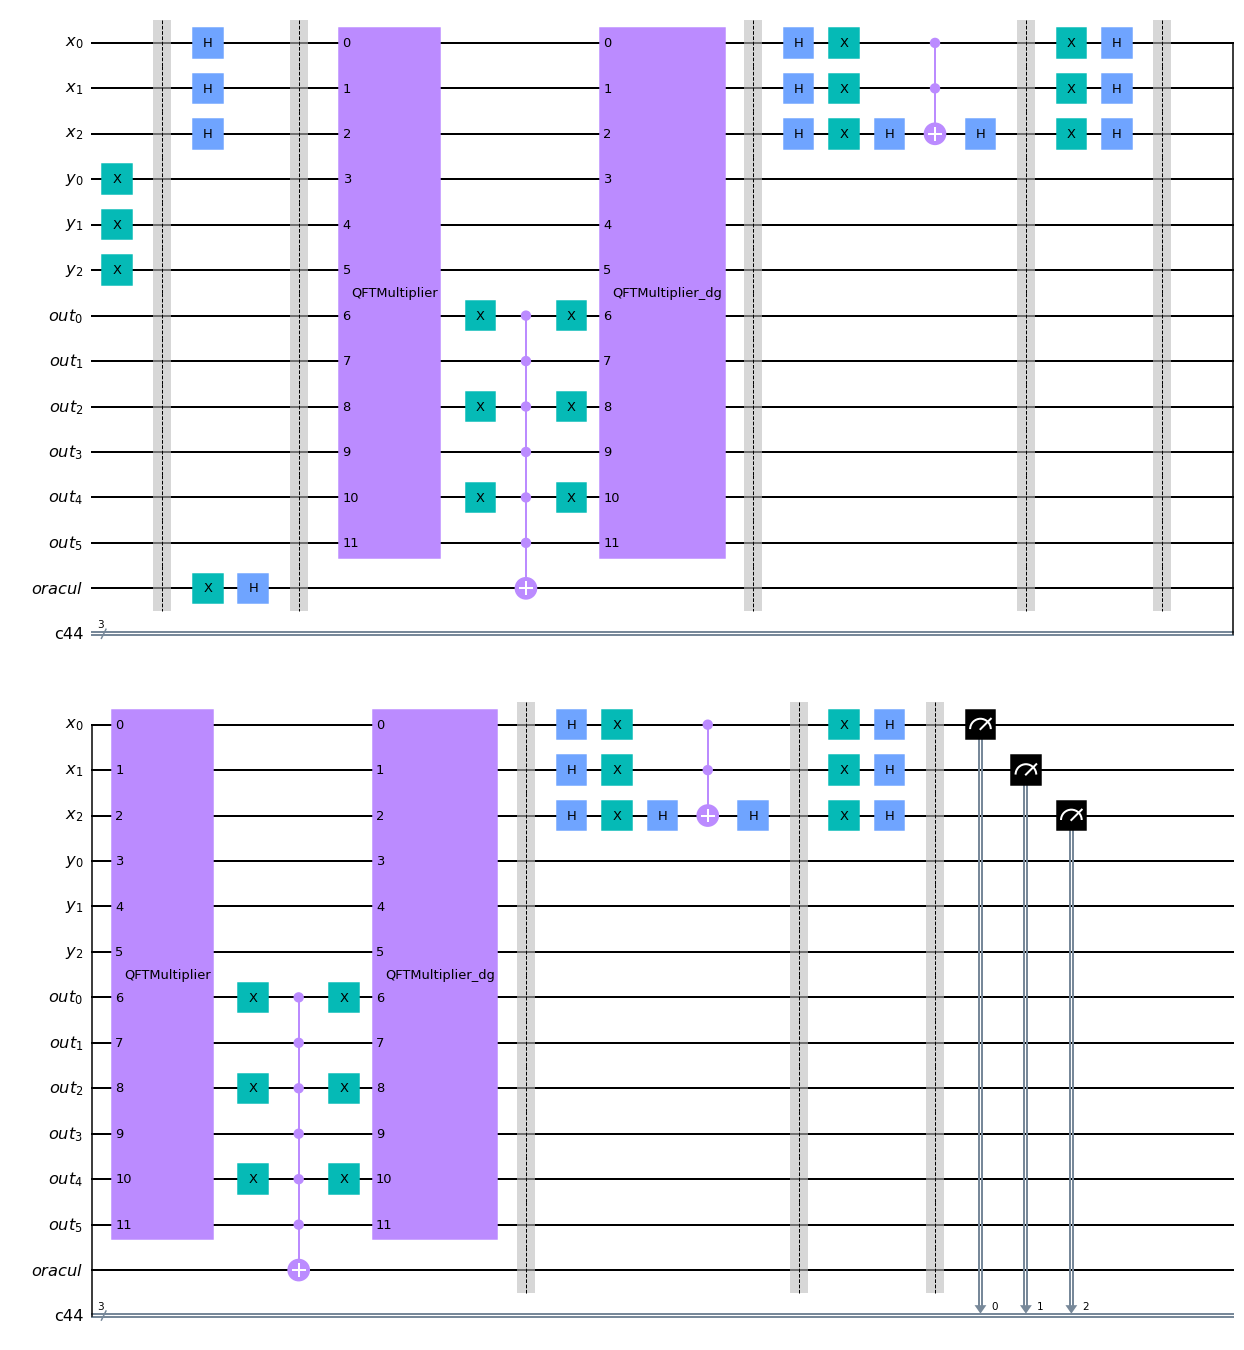

In [123]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.circuit.library.standard_gates import PhaseGate
from qiskit.visualization import plot_histogram
from qiskit import Aer, assemble, transpile
from enum import IntEnum
import numpy as np

# Перечисление для удобного использования номеров кубитов
class qubit(IntEnum):
    a_0 = 0; a_1 = 1; a_2 = 2
    b_0 = 3; b_1 = 4; b_2 = 5
    out_0 = 6; out_1 = 7; out_2 = 8; out_3 = 9; out_4 = 10; out_5 = 11
    oracul = 12

# Получение оператора квантового преобразования Фурье для заданного числа кубитов
def getQFTGate(num_qubits: int = None, name: str = "QFT"):
    
    # Завершаем функцию, если передано нулевое количество кубитов
    if num_qubits == 0: return

    circuit = QuantumCircuit(num_qubits, name=name)
    for j in reversed(range(num_qubits)):
        circuit.h(j) # Адамар
        
        # Применяем контролируемые операторы фазы (цикл [j-1...0] с шагом -1)
        for k in range(j-1, -1, -1):
            lam = np.pi * (2.0 ** (k - j))   # Высчитываем нужный угол
            circuit.cp(lam, j, k)            # Применяем операцию контролируемого изменения фазы на заданный угол

    # Возвращаем результат в виде оператора
    return circuit.to_gate()

# Получение оператора умножения (на основе QFT) для заданного числа кубитов
def getQFTMultiplierGate(num_state_qubits: int = None, num_result_qubits: int = None, name: str = "QFTMultiplier"):
    # Определение регистров и цепи
    qr_x = QuantumRegister(num_state_qubits, name="x")
    qr_y = QuantumRegister(num_state_qubits, name="y")
    qr_out = QuantumRegister(num_result_qubits, name="out")
    circuit = QuantumCircuit(qr_x, qr_y, qr_out, name= name)
    
    # Выполняем прямое преобразование Фурье над кубитами, в которых будет храниться результат (переход в другой базис)
    circuit.append(getQFTGate(num_result_qubits), qr_out[:])

    # Цикл с реализацией взвешенных сумм на основе контролируемых операторов сдвига фазы
    for i in range(1, num_state_qubits + 1):
        for j in range(1, num_state_qubits + 1):
            for k in range(1, num_result_qubits + 1):
                # Вычисляем нужный угол
                theta = (2 * np.pi) / (2**(i + j + k - 2*num_state_qubits))

                # Применяем контролируемый оператор фазы 
                circuit.append( PhaseGate(theta).control(2), [qr_x[num_state_qubits - i], qr_y[num_state_qubits - j], qr_out[k - 1]] )

    # Выполняем обратное преобразование Фурье над кубитами результата (возвращение в исходный базис)
    circuit.append(getQFTGate(num_result_qubits).inverse(), qr_out[:])

    # Возвращаем результат в виде оператора
    return circuit.to_gate()

# Применение одной итерации Гроваера к цепи (Оракул, Адамары, сдвиг фазы, Адамары)
def addGroverGate(circuit: QuantumCircuit, z:int = 6):

    ### Итерация Гровера ###
    # Получаем и применяем оператор умножения кубитов основе квантового преобразования Фурье
    multiply_gate = getQFTMultiplierGate(3,6)
    circuit.append(multiply_gate, [i for i in range(12)])

    ## 1. Оракул (сравниваем результат умножения с z) ##
    temp = z
    # Выставляем значение, с которым надо сравнить результат умножения (ставим операторы NOT)
    for i in range(6):
        if z & 0x01 == 0x00:
            circuit.x(i+6)
        z >>= 1
    circuit.mct(qr_out, q_oracul) # Применяем CNOT от N переменных к кубиту Оракула

    # Инвертируем операторы над кубитами
    for i in range(6):
        if temp & 0x01 == 0x00: 
            circuit.x(i+6)
        temp >>= 1
    circuit.append(multiply_gate.copy().inverse(), [i for i in range(12)]) # Обратное умножение
    circuit.barrier()

    ## 2. Адамары ##  
    circuit.h([i for i in range(3)])
    
    ## 3. Меняем фазу нужного нам решения ##
    circuit.x([i for i in range(3)])  # Операторы NOT   

    circuit.h(3-1)
    circuit.mct(list(range(3-1)), 3-1) # Множественный оператор CNOT
    
    # Инвертируем примененные операторы
    circuit.h(3-1)
    circuit.barrier()
    circuit.x([i for i in range(3)])    # Операторы NOT
    
    ## 4. Адамары ##
    circuit.h([i for i in range(3)])
    circuit.barrier()


############### Главная часть программы ###############
# Ищем x в уравнении вида: x*y = z
# (Можно искать решение произольного уравнения, устанавливая значения для y и z)
# Если установить значения y = 0, то на гистограмме можно будет увидить все решения уравнения вида x*y = z (при условии, что решения не превышают 7)
y = 7   # Максимум: 7
z = 42   # Максимум: 49

### Шаг 1. Инициализация регистров и  цепи ###
qr_x = QuantumRegister(3, name="x")             # Три кубита для x, который ищем
qr_y = QuantumRegister(3, name="y")             # Три кубита для y. Его значение устанавливается на схеме
qr_out = QuantumRegister(6, name="out")         # Шесть кубитов для проверки результата умножения с помощью Оракула
q_oracul = QuantumRegister(1, name="oracul")    # Кубит Оракула
cl = ClassicalRegister(3 if y != 0 else 6)      # Классические биты с результатами измерений x

circuit = QuantumCircuit(qr_x, qr_y, qr_out, q_oracul, cl)

# Устанавливаем значение 'y' в кубиты
for i in range(qr_y.size):
    if y & 0x01:
        circuit.x(i+qr_x.size)  # Применение оператора x (NOT)
    y >>= 1
circuit.barrier()       # Барьер для визуального разделения

### Шаг 2. Применяем операторы Адамара ###
# К первым кубитам, значения которых ищем, а также инициализируем кубит оракула
for i in range(cl.size):
    circuit.h(i)
circuit.x(qubit.oracul)
circuit.h(qubit.oracul)
circuit.barrier()

### Шаг 3. Итерации Гровера  ###
# (Оптимальное их количество должно быть <=, чем: (pi/4)*sqrt(Количество возможных решений / количество правильных решений)
for i in range((int)( (np.pi/4)*(np.sqrt(2**qr_x.size/1)) )):
    addGroverGate(circuit, z)

### Шаг 4. Измерения, симуляция, результат ###
# Измеряем получившиеся состояния кубитов для x
for i in range(cl.size):
    circuit.measure(i,i)

# Проводим симуляцию
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()

# Вывод значений наибольших результатов (для отладки)
print([f"counts[{i}] = {counts.get(i)}" for i in counts.keys() if counts.get(i) > 100])
circuit.draw(output="mpl")    # Рисуем цепь

# Ниже рисуется гистрограмма

counts[110] = 976
 res = 6


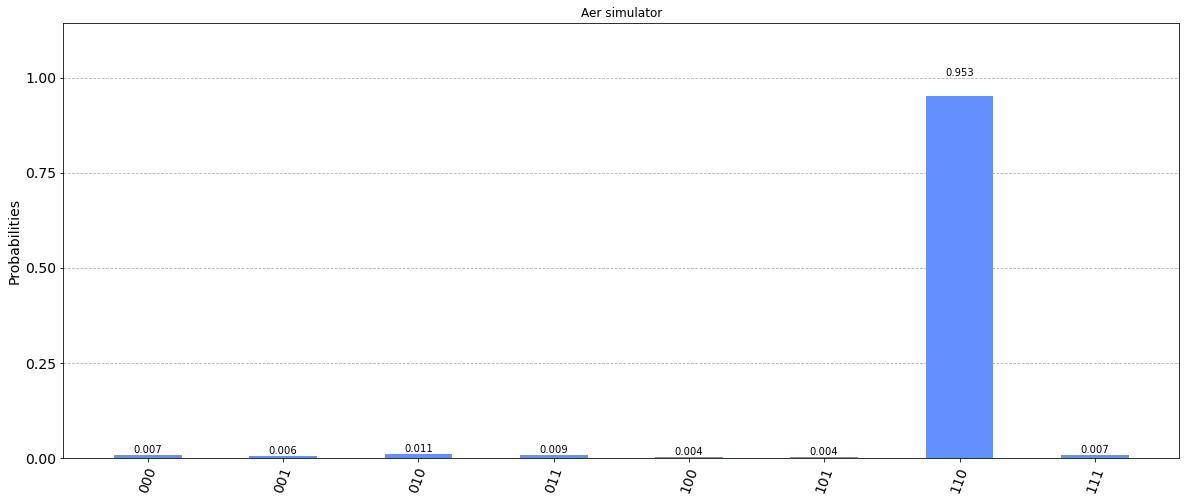

In [124]:
# Получаем результат и рисуем гистрограмму
maxValue = max(counts.values())
res = ''.join([key for key in counts.keys() if counts.get(key) == maxValue])
print(f"counts[{res}] = {maxValue}\n", f"res = {int(res, 2)}")
plot_histogram(counts, figsize=(20, 8), title='Aer simulator')